In [5]:
import time
import queue
import pandas as pd
import threading
from typing import Union, List
from tqdm import tqdm
from pathlib import Path 
import numpy as np
from datasets import Dataset
from transformers import PreTrainedTokenizerFast
from tokenizers.processors import TemplateProcessing
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from tokenizers.pre_tokenizers import Whitespace
import matplotlib.pyplot as plt
from Bio.Seq import translate
PathLike = Union[str, Path]
import re
import os
import torch

#from genslm.utils import read_fasta_only_seq, read_fasta, Sequence

# Assign a unique character to each codon so that we can use it as an
# input token to a BPE tokenizer. This implements a codon-pair encoding.
CODON_CHAR = {
    'TCG': "A", 'GCA': "B", 'CTT': "C", 'ATT': "D", 'TTA': "E", 'GGG': "F", 'CGT': "G", 
    'TAA': "H", 'AAA': "I", 'CTC': "J", 'AGT': "K", 'CCA': "L", 'TGT': "M", 'GCC': "N", 
    'GTT': "O", 'ATA': "P", 'TAC': "Q", 'TTT': "R", 'TGC': "S", 'CAC': "T", 'ACG': "U", 
    'CCC': "V", 'ATC': "W", 'CAT': "X", 'AGA': "Y", 'GAG': "Z", 'GTG': "a", 'GGT': "b", 
    'GCT': "c", 'TTC': "d", 'AAC': "e", 'TAT': "f", 'GTA': "g", 'CCG': "h", 'ACA': "i", 
    'CGA': "j", 'TAG': "k", 'CTG': "l", 'GGA': "m", 'ATG': "n", 'TCT': "o", 'CGG': "p", 
    'GAT': "q", 'ACC': "r", 'GAC': "s", 'GTC': "t", 'TGG': "u", 'CCT': "v", 'GAA': "w", 
    'TCA': "x", 'CAA': "y", 'AAT': "z", 'ACT': "0", 'GCG': "1", 'GGC': "2", 'CTA': "3", 
    'AAG': "4", 'AGG': "5", 'CAG': "6", 'AGC': "7", 'CGC': "8", 'TTG': "9", 'TCC': "!", 
    'TGA': "@"
}

def group_and_contextualize_cpe(seq: str, k: int = 3): 
    return " ".join(CODON_CHAR.get(seq[i : i + k], "") for i in range(0, len(seq), k))

def group_and_contextualize_split_every_n(seq: str, n):
    seq.replace(" ", "")
    remainder = len(seq) % n
    if remainder != 0:
        seq = seq[:-remainder]  # Remove the last remainder characters
    substrings = [seq[i:i + n] for i in range(0, len(seq), n)]
    return ' '.join(substrings)


def build_tokenizer(
    corpus_iterator,
    vocab_size,
    add_bos_eos: bool = True,
    max_length: int = 1024,
    save: bool = False,
    tokenzier_save_name: str = "cpe_tokenizer",
):
    special_tokens = {
        "unk_token": "[UNK]",
        "cls_token": "[CLS]",
        "sep_token": "[SEP]",
        "pad_token": "[PAD]",
        "mask_token": "[MASK]",
        "bos_token": "[BOS]",
        "eos_token": "[EOS]",
    }

    bos_index = 5
    eos_index = 6

    # Define tokenizer
    tokenizer = Tokenizer(models.BPE())
    
    tokenizer.pre_tokenizer = Whitespace()

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=list(special_tokens.values()),
        max_length=max_length,
    )

    print("Training tokenizer")
    tokenizer.train_from_iterator(corpus_iterator, trainer=trainer)

    # Add post-processor
    # trim_offsets=True will ignore spaces, false will leave them in
    tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
    if add_bos_eos:
        tokenizer.post_processor = TemplateProcessing(
            single="[BOS] $A [EOS]",
            special_tokens=[("[BOS]", bos_index), ("[EOS]", eos_index)],
        )

    # Add a decoder
    tokenizer.decoder = decoders.ByteLevel()

    # save the tokenizer
    wrapped_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer, **special_tokens
    )
    if save:
        wrapped_tokenizer.save_pretrained(tokenzier_save_name)
        
    print(f"Returning tokenizer with vocab_size = {vocab_size}")

    return wrapped_tokenizer

In [6]:
def read_fasta_only_seq(fasta_file: PathLike) -> List[str]:
    """Reads fasta file sequences without description tag."""
    text = Path(fasta_file).read_text()
    pattern = re.compile("^>", re.MULTILINE)
    non_parsed_seqs = re.split(pattern, text)[1:]
    lines = [
        line.replace("\n", "") for seq in non_parsed_seqs for line in seq.split("\n", 1)
    ]

    return lines[1::2]

def any_file_fasta_reader(fasta_file: PathLike) -> List[str]:
    if os.path.isdir(fasta_file):
        sequences_raw = []
        for p in Path(fasta_file).glob("*.fasta"):
            sequences_raw.extend(read_fasta_only_seq(p))
    elif os.path.isfile(fasta_file):
        sequences_raw = read_fasta_only_seq(fasta_file)
    else:
        raise ValueError(
            "Kindly enter a filepath to a directory containing many .fasta files "
            "or a filepath to a single .fasta file"
        )
    
    return sequences_raw
        

def group_and_contextualize_split_every_n(seq: str, n):
    seq.replace(" ", "")
    remainder = len(seq) % n
    if remainder != 0:
        seq = seq[:-remainder]  # Remove the last remainder characters
    substrings = [seq[i:i + n] for i in range(0, len(seq), n)]
    return ' '.join(substrings)

def group_and_contextualize_cpe(seq: str, k: int = 3): 
    return " ".join(CODON_CHAR.get(seq[i : i + k], "") for i in range(0, len(seq), k))

def make_str_div(seq, n):
    remainder = len(seq) % n
    #print(remainder)
    if remainder != 0:
        seq = seq[:-remainder]
    
    return seq

In [9]:
max_vocab_len = 40_000
increment = 5_000

def plot_vocab_lens(sequence_fasta_file: str, max_vocab_len: int, increment: int, bpe_tokenizer_type: str):
    """_summary_

    Args:
        sequences [str]: _description_
        max_vocab_len (int): _description_
        increment (int): _description_
        bpe_tokenizer_type (str): choices: ["ape_tokenizer", "cpe_tokenizer", "npe_tokenizer"]
    """
    
    dna_sequences = any_file_fasta_reader(sequence_fasta_file)
    
    
     # data preprocessing dependent on tokenizer_type
    if bpe_tokenizer_type == "ape_tokenizer":
        sequences = [group_and_contextualize_split_every_n(translate(make_str_div(seq.upper()), 1)) for seq in dna_sequences]
    
    elif bpe_tokenizer_type == "cpe_tokenizer":
        sequences = [group_and_contextualize_cpe(make_str_div(seq.upper(), 3)) for seq in dna_sequences]
        
    elif bpe_tokenizer_type == "npe_tokenizer":
        sequences = [group_and_contextualize_split_every_n(make_str_div(seq.upper(), 1)) for seq in dna_sequences]

    else:
        raise ValueError("Please enter a valid bpe_tokenizer_type :)")


    num_tokens_in_vocab = {}
    per_vocab_in_vocab = {}
    
    for vocab_size in range(increment, max_vocab_len, increment):
        tokenizer = build_tokenizer(sequences, vocab_size)
        
        unique_lens = []
        print(f"Finding lens for {vocab_size}")
        for seq in tqdm(sequences):
            
            tokenized_seq = tokenizer(seq, max_length=1024, padding="max_length", truncation=True, return_tensors="pt")
            unique_lens.append(len(torch.unique(tokenized_seq['input_ids'])))


        avg_num_unique_tokens = (sum(unique_lens)/len(unique_lens))
        
        num_tokens_in_vocab[vocab_size] = avg_num_unique_tokens
        
        
    for key, value in num_tokens_in_vocab.items():
        per_vocab_in_vocab[key] = value/key
    
    
    plt.scatter(num_tokens_in_vocab.keys(), num_tokens_in_vocab.values())
    plt.title(bpe_tokenizer_type + " absolute avg num unique tokens")
    plt.xlabel("Vocab Size")
    plt.ylabel("Num Unique Tokens Used")
    plt.show()
    
    plt.scatter(per_vocab_in_vocab.keys(), per_vocab_in_vocab.values())
    plt.title(bpe_tokenizer_type + " relative avg num unique tokens")
    plt.xlabel("Vocab Size")
    plt.ylabel("Percentage of Vocab Size Used")
    plt.show()
    



Training tokenizer
Ignored unknown kwargs option max_length



Returning tokenizer with vocab_size = 200
Finding lens for 200


100%|██████████| 36631/36631 [00:50<00:00, 724.36it/s] 


Training tokenizer
Ignored unknown kwargs option max_length



Returning tokenizer with vocab_size = 400
Finding lens for 400


100%|██████████| 36631/36631 [00:49<00:00, 747.28it/s] 


Training tokenizer
Ignored unknown kwargs option max_length



Returning tokenizer with vocab_size = 600
Finding lens for 600


100%|██████████| 36631/36631 [00:53<00:00, 679.87it/s] 


Training tokenizer
Ignored unknown kwargs option max_length



Returning tokenizer with vocab_size = 800
Finding lens for 800


100%|██████████| 36631/36631 [00:51<00:00, 712.70it/s] 


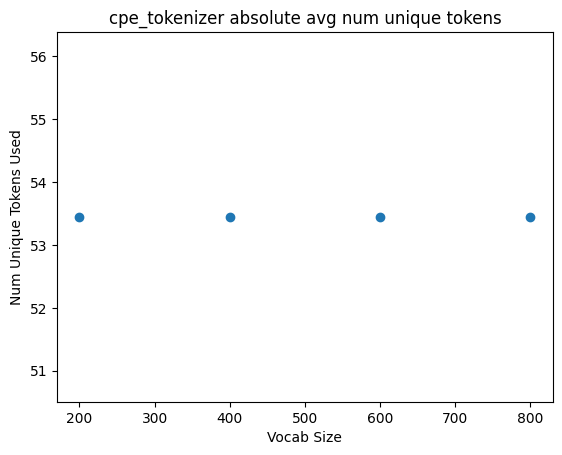

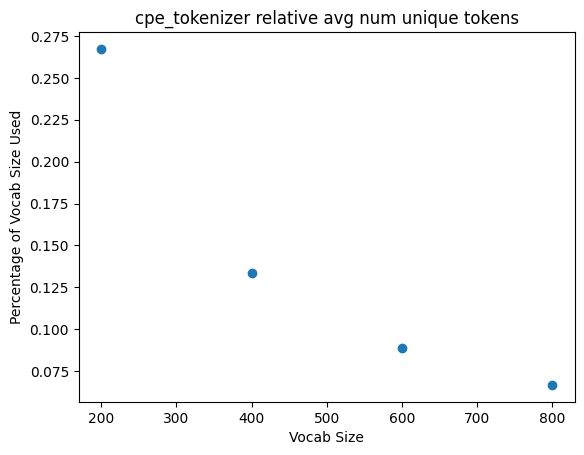

In [12]:
plot_vocab_lens(sequence_fasta_file='/home/couchbucks/Downloads/all_fasta_files/mdh_natural_sequences.ffn', max_vocab_len=1000, increment=200, bpe_tokenizer_type='cpe_tokenizer')